In [1]:
import numpy as np
import os
import cv2
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.optimizers import RMSprop, Adam, Adadelta
from keras.layers import Input, Embedding, Dense, Dropout, Flatten
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,BatchNormalization,GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau
import imutils
%matplotlib inline
import math
import matplotlib.pyplot
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot
image_size1 = 85
image_size2 = 128
from sklearn.model_selection import train_test_split,KFold
from sklearn.model_selection import cross_val_score
from keras import backend as K
K.set_image_dim_ordering('th')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def load_train(simul):
    X_train = []
    y_train = []
    train_ds = pd.read_csv('Train.csv')
    print('Read train images')
    for index, row in train_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.transpose((2,0,1))
        X_train.append(img)
        if simul == 0:
            y_train.append(row['Competency_Score'])
        elif simul == 1:
            y_train.append(row['Trustworthy_Score'])
        else:    
            y_train.append([row['Competency_Score'],row['Trustworthy_Score']])         
    return X_train, y_train  

def read_and_normalize_train_data(simul,k= 3):
    train_data, train_target = load_train(simul)       
    train_data = np.array(train_data, dtype=np.float32)
    train_target = np.array(train_target, dtype=np.float32)
    print("Train data shape",train_data.shape)
    print("Train target shape",train_target.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target

# Image generators
def imagegen(config):
    if config == 1:
        datagen = ImageDataGenerator(
        rotation_range=120,
        zoom_range=0.40,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255,
        validation_split = 0.9)
    elif config == 2:
        datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=120,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255,
        validation_split = 0.9)
    elif config ==3:
        datagen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         rescale=1./255,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10)
    return datagen 

def create_model(config,output):
    if config == 1:
        input_layer = Input(shape=(3,image_size2,image_size1))
        x = Conv2D(16, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)
        x = Conv2D(32, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)
        x = Conv2D(64, 3,activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x) 
        x = Flatten()(x)     
        x = Dense(500, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(100, activation='relu')(x)
        x = Dropout(0.25)(x)
        x = Dense(20, activation='relu')(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(input_layer, output_layer)
        model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
        return model
    elif config == 2: 
        input_layer = Input(shape=(3,image_size2,image_size1))
        x = Conv2D(32, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)
        x = Flatten()(x)     
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(input_layer, output_layer)
        model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
        return model
    elif config == 3:
        input_layer = Input(shape=(3,image_size2,image_size1))
        x = Conv2D(32, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)       
#         x = BatchNormalization(axis= 3)  
        x = Conv2D(64, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)        
#         x = BatchNormalization(axis= 3)    
        x = Conv2D(128, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)        
#         x = BatchNormalization(axis = 3)(x)
        x = Conv2D(64, 3, activation='relu')(x)
        x = GlobalAveragePooling2D()(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(input_layer, output_layer)
        model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
        
        return model
def get_callbacks(name_weights, patience_lr,patience_es):
    mcp_save = ModelCheckpoint(name_weights,verbose=1,save_best_only=True, monitor='val_loss', mode='min')
    earlystopping = EarlyStopping(monitor='val_loss',patience=patience_es, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, min_delta=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss,earlystopping]

# Simultaneous Regression

In [3]:
x,y = read_and_normalize_train_data(simul = None)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
model = create_model(config = 3,output = 2)
for j, (train_idx, val_idx) in enumerate(kfold.split(x,y)): 
    batch_size=50
    print('\nFold ',j)
    X_train_cv = x[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = x[val_idx]
    y_valid_cv= y[val_idx] 
    STEP_SIZE_TRAIN=len(X_train_cv)//batch_size
    STEP_SIZE_VALID=len(X_valid_cv)//batch_size
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=5,patience_es = 5)
    gen = imagegen(3)
    datagen_v = ImageDataGenerator(rescale=1./255)
    gen.fit(X_train_cv)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    generator_v = datagen_v.flow(X_valid_cv, y_valid_cv, batch_size = batch_size)
    model.fit_generator(
                generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                epochs=10,
                shuffle=True,
                verbose=1,
                validation_data = generator_v,
                validation_steps=STEP_SIZE_VALID,
                callbacks = callbacks)
    print(model.metrics_names)
    print(model.evaluate_generator(generator=generator_v,steps=STEP_SIZE_VALID))

Read train images
Train data shape (800, 3, 128, 85)
Train target shape (800, 2)
800 train samples

Fold  0
Epoch 1/10
12/12 [==============================] - 122s 10s/step - loss: 39.1620 - mean_absolute_error: 5.9654 - val_loss: 42.5442 - val_mean_absolute_error: 6.2825

Epoch 00001: val_loss improved from inf to 42.54422, saving model to final_model_fold0_weights.h5
Epoch 2/10
12/12 [==============================] - 111s 9s/step - loss: 38.2562 - mean_absolute_error: 5.8827 - val_loss: 39.2380 - val_mean_absolute_error: 5.9907

Epoch 00002: val_loss improved from 42.54422 to 39.23802, saving model to final_model_fold0_weights.h5
Epoch 3/10
12/12 [==============================] - 111s 9s/step - loss: 39.4830 - mean_absolute_error: 5.9836 - val_loss: 41.1604 - val_mean_absolute_error: 6.1687

Epoch 00003: val_loss did not improve from 39.23802
Epoch 4/10
12/12 [==============================] - 121s 10s/step - loss: 38.7506 - mean_absolute_error: 5.9320 - val_loss: 43.4236 - val_me

12/12 [==============================] - 73s 6s/step - loss: 40.1638 - mean_absolute_error: 6.0371 - val_loss: 38.9073 - val_mean_absolute_error: 5.9693

Epoch 00008: val_loss did not improve from 38.67769
Epoch 9/10
12/12 [==============================] - 76s 6s/step - loss: 38.9404 - mean_absolute_error: 5.9447 - val_loss: 38.9355 - val_mean_absolute_error: 5.9731

Epoch 00009: val_loss did not improve from 38.67769
Restoring model weights from the end of the best epoch
Epoch 00009: early stopping
['loss', 'mean_absolute_error']
[38.018545324152164, 5.854000091552734]

Fold  4
Epoch 1/10
12/12 [==============================] - 76s 6s/step - loss: 39.7591 - mean_absolute_error: 6.0206 - val_loss: 39.0520 - val_mean_absolute_error: 5.9567

Epoch 00001: val_loss improved from inf to 39.05197, saving model to final_model_fold4_weights.h5
Epoch 2/10
12/12 [==============================] - 73s 6s/step - loss: 39.1228 - mean_absolute_error: 5.9677 - val_loss: 39.3915 - val_mean_absolute_

In [4]:
#Unknown Predictions
test_ds = pd.read_csv('Test_p.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a) 
# Test Results
a = np.array(y)
a = a.reshape(-1,2)
df_results = pd.DataFrame()
df_results['Image_Name'] = x
df_results['Combined Test Score'] = y
df_results[['Competency_Score_P','Trustworthy_Score_P']] = pd.DataFrame(a)
df_results['Competency_Score_P'] = round(df_results['Competency_Score_P'], 2)
df_results['Trustworthy_Score_P'] = round(df_results['Trustworthy_Score_P'], 2)
df_results['Competency_Score_A'] = test_ds['Competency_Score']
df_results['Trustworthy_Score_A'] = test_ds['Trustworthy_Score']
df_results = df_results[['Image_Name', 'Competency_Score_P', 'Trustworthy_Score_P','Competency_Score_A','Trustworthy_Score_A']]
print(df_results.head(5))  
mae_comp = np.sum(np.absolute(df_results['Competency_Score_P'] - df_results['Competency_Score_A']))/len(df_results)
mae_trust = np.sum(np.absolute(df_results['Trustworthy_Score_P'] - df_results['Trustworthy_Score_A']))/len(df_results)
print("MAE Competency:", mae_comp)
print("MAE Trustworthy:", mae_trust)
print("MAE Combined:", mae_trust+mae_comp)

  Image_Name  Competency_Score_P  Trustworthy_Score_P  Competency_Score_A  \
0   B268.jpg                 0.0                  0.0                3.00   
1   B287.jpg                 0.0                  0.0                8.00   
2   B467.jpg                 0.0                  0.0                7.67   
3   B506.jpg                 0.0                  0.0                5.88   
4   B292.jpg                 0.0                  0.0                9.00   

   Trustworthy_Score_A  
0                 5.00  
1                 2.50  
2                 6.67  
3                 5.62  
4                 9.00  
MAE Competency: 6.12089552238806
MAE Trustworthy: 5.987313432835822
MAE Combined: 12.108208955223882


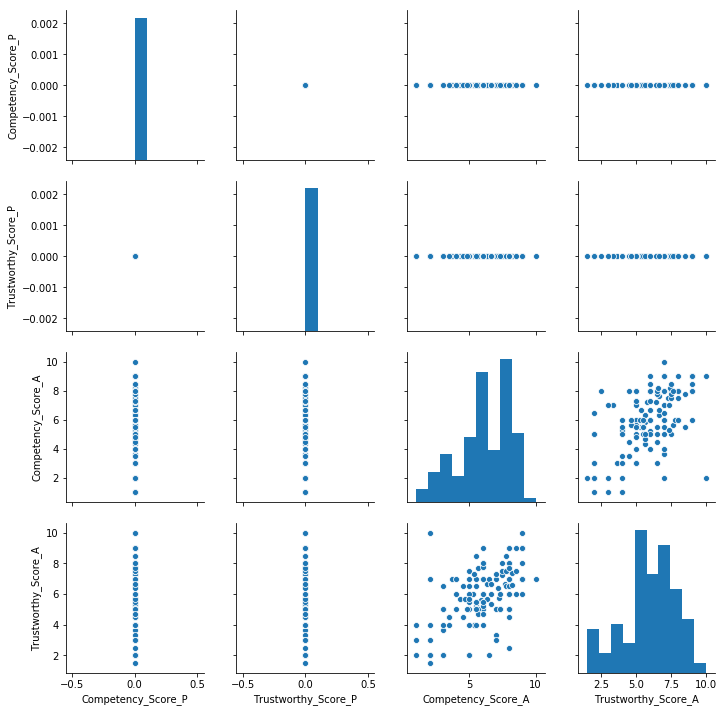

In [5]:
sns.pairplot(df_results)

# Individual Regression - Only on Competency Score

In [6]:
cv_size = 50
x,y = read_and_normalize_train_data(simul = 0)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
model = create_model(config = 3,output = 1)
for j, (train_idx, val_idx) in enumerate(kfold.split(x,y)): 
    batch_size=50
    print('\nFold ',j)
    X_train_cv = x[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = x[val_idx]
    y_valid_cv= y[val_idx] 
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=5,patience_es = 10)
    gen = imagegen(3)
    STEP_SIZE_TRAIN=len(X_train_cv)//batch_size
    STEP_SIZE_VALID=len(X_valid_cv)//batch_size
    datagen_v = ImageDataGenerator(rescale=1./255)
    gen.fit(X_train_cv)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    generator_v = datagen_v.flow(X_valid_cv, y_valid_cv, batch_size = batch_size)
    model.fit_generator(
                generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                epochs=10,
                shuffle=True,
                verbose=1,
                validation_data = generator_v,
                validation_steps=STEP_SIZE_VALID,
                callbacks = callbacks)
    print(model.metrics_names)
    print(model.evaluate_generator(generator=generator_v,steps=STEP_SIZE_VALID))

Read train images
Train data shape (800, 3, 128, 85)
Train target shape (800,)
800 train samples

Fold  0
Epoch 1/10
12/12 [==============================] - 78s 7s/step - loss: 15.3736 - mean_absolute_error: 3.2316 - val_loss: 7.5725 - val_mean_absolute_error: 2.3423

Epoch 00001: val_loss improved from inf to 7.57248, saving model to final_model_fold0_weights.h5
Epoch 2/10
12/12 [==============================] - 73s 6s/step - loss: 5.3066 - mean_absolute_error: 1.8386 - val_loss: 4.6103 - val_mean_absolute_error: 1.6982

Epoch 00002: val_loss improved from 7.57248 to 4.61030, saving model to final_model_fold0_weights.h5
Epoch 3/10
12/12 [==============================] - 72s 6s/step - loss: 4.4548 - mean_absolute_error: 1.6912 - val_loss: 3.7783 - val_mean_absolute_error: 1.5573

Epoch 00003: val_loss improved from 4.61030 to 3.77832, saving model to final_model_fold0_weights.h5
Epoch 4/10
12/12 [==============================] - 72s 6s/step - loss: 5.0383 - mean_absolute_error: 1.8

12/12 [==============================] - 64s 5s/step - loss: 3.5892 - mean_absolute_error: 1.5296 - val_loss: 3.3030 - val_mean_absolute_error: 1.4585

Epoch 00004: val_loss improved from 3.77881 to 3.30302, saving model to final_model_fold3_weights.h5
Epoch 5/10
12/12 [==============================] - 90s 7s/step - loss: 4.3016 - mean_absolute_error: 1.6805 - val_loss: 3.8963 - val_mean_absolute_error: 1.5440

Epoch 00005: val_loss did not improve from 3.30302
Epoch 6/10
12/12 [==============================] - 89s 7s/step - loss: 4.0473 - mean_absolute_error: 1.6588 - val_loss: 4.3010 - val_mean_absolute_error: 1.5681

Epoch 00006: val_loss did not improve from 3.30302
Epoch 7/10
12/12 [==============================] - 88s 7s/step - loss: 3.3576 - mean_absolute_error: 1.5027 - val_loss: 3.6583 - val_mean_absolute_error: 1.3864

Epoch 00007: val_loss did not improve from 3.30302
Epoch 8/10
12/12 [==============================] - 89s 7s/step - loss: 3.6180 - mean_absolute_error: 1.5

  Image_Name  Competency_Score_P  Competency_Score_A
0   B268.jpg                8.22                3.00
1   B287.jpg                8.14                8.00
2   B467.jpg                9.03                7.67
3   B506.jpg                7.21                5.88
4   B292.jpg                9.24                9.00
MAE Competency: 2.4319403125990684


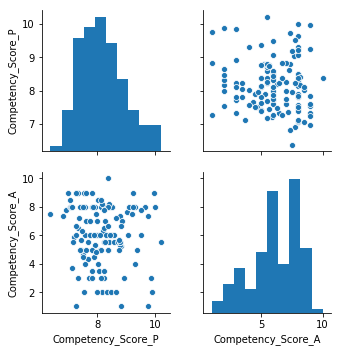

In [7]:
#Unknown Predictions
test_ds = pd.read_csv('Test_p.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a) 
# Test Results
a = np.array(y)
a = a.reshape(-1,1)
df_results = pd.DataFrame()
df_results['Image_Name'] = x
df_results[['Competency_Score_P']] = pd.DataFrame(a)
df_results['Competency_Score_P'] = round(df_results['Competency_Score_P'], 2)
df_results['Competency_Score_A'] = test_ds['Competency_Score']
df_results = df_results[['Image_Name', 'Competency_Score_P','Competency_Score_A']]
print(df_results.head(5))
mae_comp = np.sum(np.absolute(df_results['Competency_Score_P'] - df_results['Competency_Score_A']))/len(df_results)
print("MAE Competency:", mae_comp)
sns.pairplot(df_results)

# Individual Regression - Only on Trustworthy Score

In [8]:
cv_size = 50
x,y = read_and_normalize_train_data(simul = 1)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
model = create_model(config = 3,output = 1)
for j, (train_idx, val_idx) in enumerate(kfold.split(x,y)): 
    batch_size=50
    print('\nFold ',j)
    X_train_cv = x[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = x[val_idx]
    y_valid_cv= y[val_idx] 
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=5,patience_es = 10)
    gen = imagegen(3)
    STEP_SIZE_TRAIN=len(X_train_cv)//batch_size
    STEP_SIZE_VALID=len(X_valid_cv)//batch_size
    datagen_v = ImageDataGenerator(rescale=1./255)
    gen.fit(X_train_cv)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    generator_v = datagen_v.flow(X_valid_cv, y_valid_cv, batch_size = batch_size)
    model.fit_generator(
                generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                epochs=10,
                shuffle=True,
                verbose=1,
                validation_data = generator_v,
                validation_steps=STEP_SIZE_VALID,
                callbacks = callbacks)
    print(model.metrics_names)
    print(model.evaluate_generator(generator=generator_v,steps=STEP_SIZE_VALID))

Read train images
Train data shape (800, 3, 128, 85)
Train target shape (800,)
800 train samples

Fold  0
Epoch 1/10
12/12 [==============================] - 47s 4s/step - loss: 16.8703 - mean_absolute_error: 3.3786 - val_loss: 4.9460 - val_mean_absolute_error: 1.8194

Epoch 00001: val_loss improved from inf to 4.94601, saving model to final_model_fold0_weights.h5
Epoch 2/10
12/12 [==============================] - 41s 3s/step - loss: 5.3945 - mean_absolute_error: 1.9105 - val_loss: 4.4104 - val_mean_absolute_error: 1.6708

Epoch 00002: val_loss improved from 4.94601 to 4.41044, saving model to final_model_fold0_weights.h5
Epoch 3/10
12/12 [==============================] - 40s 3s/step - loss: 4.8117 - mean_absolute_error: 1.7917 - val_loss: 3.7550 - val_mean_absolute_error: 1.5338

Epoch 00003: val_loss improved from 4.41044 to 3.75504, saving model to final_model_fold0_weights.h5
Epoch 4/10
12/12 [==============================] - 39s 3s/step - loss: 4.6996 - mean_absolute_error: 1.7

12/12 [==============================] - 38s 3s/step - loss: 3.7015 - mean_absolute_error: 1.5756 - val_loss: 3.1084 - val_mean_absolute_error: 1.3430

Epoch 00004: val_loss did not improve from 2.66053
Epoch 5/10
12/12 [==============================] - 39s 3s/step - loss: 3.7700 - mean_absolute_error: 1.5950 - val_loss: 3.0613 - val_mean_absolute_error: 1.3183

Epoch 00005: val_loss did not improve from 2.66053
Epoch 6/10
12/12 [==============================] - 38s 3s/step - loss: 3.7400 - mean_absolute_error: 1.5829 - val_loss: 2.8517 - val_mean_absolute_error: 1.3350

Epoch 00006: val_loss did not improve from 2.66053

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 7/10
12/12 [==============================] - 38s 3s/step - loss: 3.5672 - mean_absolute_error: 1.5326 - val_loss: 3.1717 - val_mean_absolute_error: 1.2959

Epoch 00007: val_loss did not improve from 2.66053
Epoch 8/10
12/12 [==============================] - 39s 3s/step - loss: 3

  Image_Name  Trustworthy_Score_P  Trustworthy_Score_A
0   B268.jpg                 9.69                 5.00
1   B287.jpg                 9.26                 2.50
2   B467.jpg                 9.66                 6.67
3   B506.jpg                 8.48                 5.62
4   B292.jpg                10.15                 9.00
MAE Trustworthy: 2.915671652466504


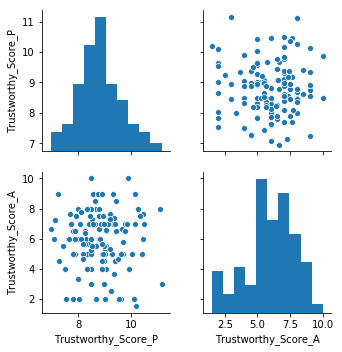

In [9]:
#Unknown Predictions
test_ds = pd.read_csv('Test_p.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a) 
# Test Results
a = np.array(y)
a = a.reshape(-1,1)
df_results = pd.DataFrame()
df_results['Image_Name'] = x
df_results[['Trustworthy_Score_P']] = pd.DataFrame(a)
df_results['Trustworthy_Score_P'] = round(df_results['Trustworthy_Score_P'], 2)
df_results['Trustworthy_Score_A'] = test_ds['Trustworthy_Score']
df_results = df_results[['Image_Name','Trustworthy_Score_P','Trustworthy_Score_A']]
print(df_results.head(5))
mae_trust = np.sum(np.absolute(df_results['Trustworthy_Score_P'] - df_results['Trustworthy_Score_A']))/len(df_results)
print("MAE Trustworthy:", mae_trust)
sns.pairplot(df_results)